In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import math
import numpy as np

In [2]:
train = pd.read_csv('training_data.csv', index_col='Unnamed: 0')
train.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Month,StoreType,Assortment,CompetitionDistance,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
0,1,5,5263,1,1,0,1,7,3,1,0.016741,0,0,0,1
1,1,4,5020,1,1,0,1,7,3,1,0.016741,0,0,0,1
2,1,3,4782,1,1,0,1,7,3,1,0.016741,0,0,0,1
3,1,2,5011,1,1,0,1,7,3,1,0.016741,0,0,0,1
4,1,1,6102,1,1,0,1,7,3,1,0.016741,0,0,0,1


Epoch 1/50
44503/44503 [==============================] - 117s 3ms/step - loss: 8.2441e-04 - mae: 0.0213 - val_loss: 0.3427 - val_mae: 0.5849
Epoch 2/50
44503/44503 [==============================] - 112s 3ms/step - loss: 6.0405e-04 - mae: 0.0196 - val_loss: 0.0529 - val_mae: 0.2285
Epoch 3/50
44503/44503 [==============================] - 112s 3ms/step - loss: 6.0090e-04 - mae: 0.0195 - val_loss: 0.0033 - val_mae: 0.0554
Epoch 4/50
44503/44503 [==============================] - 114s 3ms/step - loss: 6.0530e-04 - mae: 0.0196 - val_loss: 0.1613 - val_mae: 0.4007
Epoch 5/50
44503/44503 [==============================] - 113s 3ms/step - loss: 5.9670e-04 - mae: 0.0195 - val_loss: 0.0043 - val_mae: 0.0635
Epoch 6/50
44503/44503 [==============================] - 115s 3ms/step - loss: 5.9960e-04 - mae: 0.0195 - val_loss: 0.0654 - val_mae: 0.2420
Epoch 7/50
44503/44503 [==============================] - 113s 3ms/step - loss: 6.0000e-04 - mae: 0.0195 - val_loss: 0.0081 - val_mae: 0.0722
Epoch 

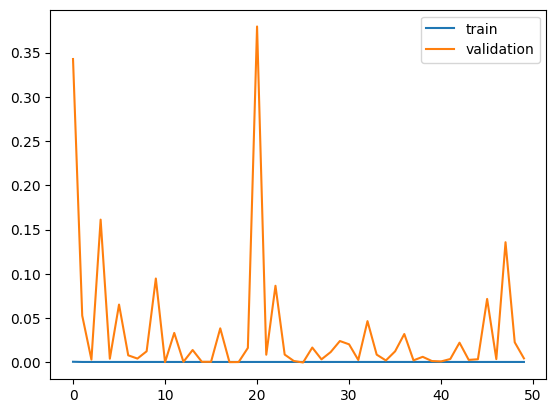

In [3]:
# number of input columns
X = train['Sales'].to_numpy().reshape(-1, 1)
y = train.drop(columns=['Sales'])
n_inputs = X.shape[1]

# split into train validation test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.4, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_valid = t.transform(X_valid)

visible = Input(shape=(n_inputs,))

# first encoder
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)

# second encoder
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = ReLU()(e)

# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

# first decoder
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)

# second decoder
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = ReLU()(d)

output = Dense(n_inputs, activation='linear')(d)

model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=["mae"])
history = model.fit(X_train, X_train, epochs=50, batch_size=16, validation_data=(X_valid,X_valid))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [4]:
def rmse(y_true, y_pred):
    return math.sqrt(np.mean(np.square(y_pred - y_true)))

In [5]:
def rmspe(y_true, y_pred):
    return math.sqrt(np.mean(np.square((y_true - y_pred)/np.mean(y_true))))

In [6]:
X_test = t.transform(X_test)
p = model.predict(X_test)
metric = tf.keras.metrics.R2Score()
metric.update_state(X_test, p)
result = metric.result()

print(result.numpy())
print(rmse(X_test, p))
print(rmspe(X_test, p))

3815/3815 [==============================] - 5s 1ms/step
0.5337163
0.06804017765452455
0.4558788431827658


In [7]:
test = pd.read_csv('testing_data.csv', index_col='Unnamed: 0')
test.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Month,StoreType,Assortment,CompetitionDistance,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
0,1,4,1.0,1,0,0,9,3,1,0.016741,0,0,0,1
48,3,4,1.0,1,0,0,9,1,1,0.186264,0,1,0,0
96,7,4,1.0,1,0,0,9,1,3,0.316372,0,0,0,1
144,8,4,1.0,1,0,0,9,1,1,0.099130,0,0,0,1
192,9,4,1.0,1,0,0,9,1,3,0.026760,0,0,0,1


In [8]:
prediction = model.predict(test.to_numpy().reshape(-1, 1))
pred = pd.DataFrame(prediction, columns=['Sales'])
pred.insert(0, 'Id', range(1, 1 + len(pred)))
pred.to_csv("../rossmann-store-sales/data_prediction.csv", index=False)
pred.head()

17976/17976 [==============================] - 23s 1ms/step


,Id,Sales
0,1,1.149526
1,2,4.286086
2,3,1.149526
3,4,1.149526
4,5,0.046843
